# Nonparametric Differential Equations (npde)

This document describes how to use the software implementation of our **npsde** (nonparametric stochastic differential equations) model. The implementation is in python3.5 and requires __[TensorFlow(1.6.0+)](https://www.tensorflow.org/)__ and __[GPflow(1.1+)](https://github.com/GPflow/GPflow)__. To learn more about the model, __[here](https://arxiv.org/abs/1807.05748)__ is a link to the our paper to be presented in MLSP in September 2018. This repository also overrides the MATLAB implementation of **npODE** model for learning ordinary differential equations (__[here](http://proceedings.mlr.press/v80/heinonen18a/heinonen18a.pdf)__ is the npODE ICML 2018 paper and __[here](https://github.com/cagatayyildiz/npode)__ is the old MATLAB implementation).

&nbsp;

**Notebook Sections**

The notebook consists of three sections, each containing an example fit where the underlying dynamics are governed by an ODE, SDE with constant diffusion, and SDE with state dependent diffusion. Van der Pol (VDP) oscillator, whose dynamics are given by equations below, is used as the running example:
\begin{align*}
\frac{dx_1}{dt} = x_2 \qquad \qquad \frac{dx_2}{dt} &= (1-x_1^2) x_2 - x_1 
\end{align*}
In examples below, true constant diffusion is equal to 0.2 and the state dependent diffusion function is given by $g(x)=3\mathcal{N}(x;[-2,0],0.5I)$. The model is completely unaware of the dynamics, and infers the dynamics by placing Gaussian process priors over the drift and diffusion functions and computing the posterior.

&nbsp;

**Main Functions**

There are three main python functions that provide an easy-to-use interface to the model implementation:
 * ```npde_fit``` -  fits the model (ODE/SDE) to the input data and observed time points  
 * `predict` - a class function that predicts signals given a `npde` model that stores the learned SDE dynamics, an initial value and observed time points   
 * `sample` - a class function that draws samples from a learned SDE system signals given the same input in `predict` function

&nbsp;

**For Better Performance**

The quality of the fit relies on many factors including the width of the inducing point grid `W`, lengthscales `ell`, learning rate `eta`, number of optimization steps `num_iter` and number of samples `Nw` used for optimization in SDEs. Few notes about enhancing the performance: 
 * In general, a denser inducing point grid and more samples for SDEs are better - the higher `W` and `Nw`, the better. 
 * Learning rate must always be carefully tuned for every problem and even data set.
 * Higher lengthscale values result in smoother trajectories. Although optimized, we reserve it for model selection. For example in modeling constant diffusions, lengthscale of the diffusion function must be high, e.g., $10^5$. It is also a good idea to perform the optimization several times over a grid of lengthscales. For instance, a good grid in case of VDP oscillator with `W=5` would be `linspace(0.75,4,10`).
 * It should also be noted that `W` and `ell` should be tuned together carefully. In general, if one is increased, then the other should be decreased.

## Preparing the Environment

In [22]:
%load_ext autoreload
%autoreload 2

# avoid GPU due to Cholesky decompositions
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.InteractiveSession()

import numpy as np
from utils import gen_data
from npde_helper import npde_fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. ODE

### Data Generation

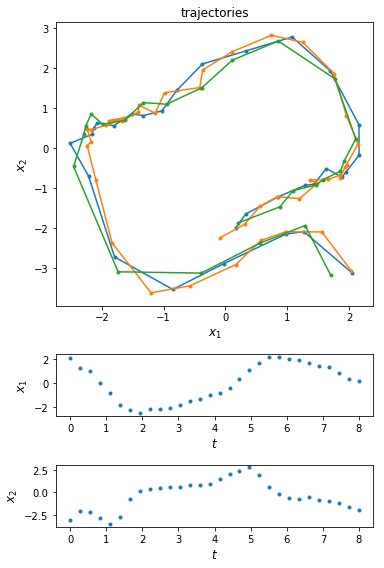

In [9]:
np.random.seed(918273) # just for illustration purposes
x0,t,Y,X,D,f,g = gen_data('vdp', Ny=[35,40,30], tend=8, nstd=0.1)

Help on function gen_data in module utils:

gen_data(model='vdp', Ny=[30], tend=8, x0=array([ 2., -3.]), nstd=0.1)



###  Inference

In [11]:
# t - observation times, a python array of numpy vectors
# Y - observations, a python array of numpy matrices, data points are in rows
# step size (eta) must be carefully tuned for different data sets
npde = npde_fit(sess, t, Y, model='ode', sf0=1.0, ell0=np.ones(2), W=6, ktype="id",
                num_iter=500, print_int=100, eta=0.02, plot_=True)

Model being initialized...
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1         233.165


KeyboardInterrupt: 

## 2. SDE with Constant Diffusion

### Data Generation

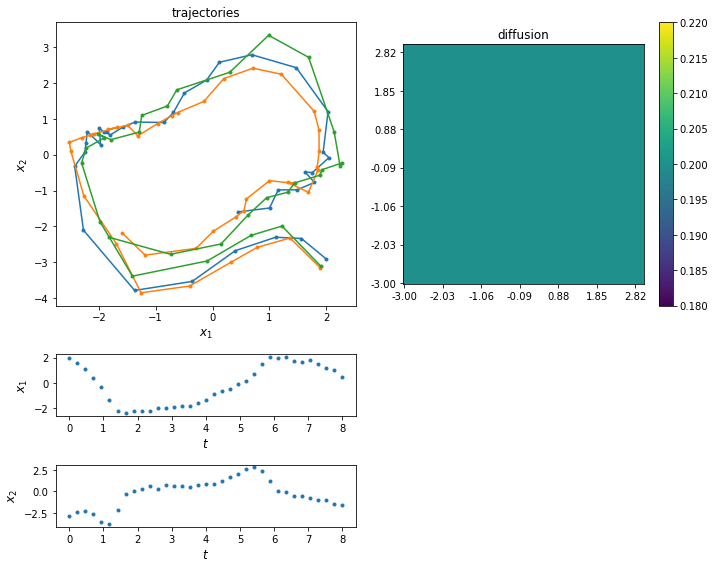

In [12]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-cdiff', Ny=[35,40,30], tend=8, nstd=0.1)

### Inference

In [20]:
help(gen_data)

Help on function gen_data in module utils:

gen_data(model='vdp', Ny=[30], tend=8, x0=array([ 2., -3.]), nstd=0.1)



In [ ]:
# in order to constant diffusion, lengthscale of the diffusion process (ellg0) must be big
npde = npde_fit(sess, t, Y, model='sde', sf0=1.0, ell0=np.ones(2), ellg0=[1e5], W=6, 
                ktype="id", Nw=50, num_iter=500, print_int=100, eta=0.02, plot_=True)

Model being initialized...
Adam optimizer being initialized...
Optimization starts.
       iteration       objective


### Predictions

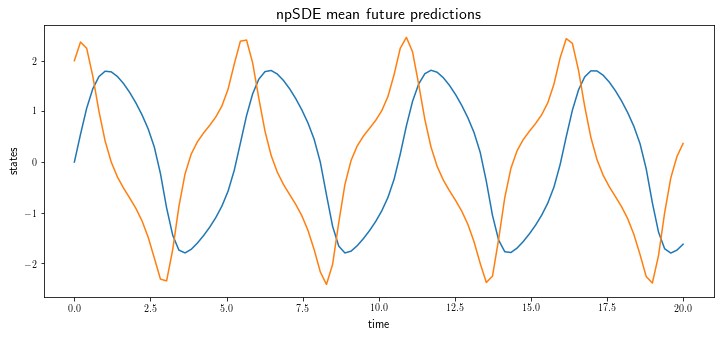

In [6]:
x0 = [0,2] # initial value
t = np.linspace(0,20,100) # time points 
path = npde.predict(x0,t)
path = sess.run(path)

plt.figure(figsize=(12,5))
plt.plot(t,path)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE mean future predictions',fontsize=16);

### Sampling

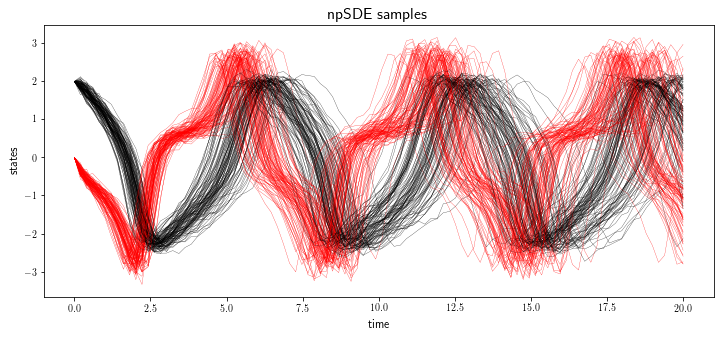

In [7]:
x0 = [2,0]
t = np.linspace(0,20,100)
Nw = 100 # number of samples
samples = npde.sample(Nw=100,x0=x0,t=t)
samples = sess.run(samples)

plt.figure(figsize=(12,5))
for i in range(Nw):
    plt.plot(t,samples[i,:,0],'-k',linewidth=0.25)
    plt.plot(t,samples[i,:,1],'-r',linewidth=0.25)
plt.xlabel('time',fontsize=12)
plt.ylabel('states',fontsize=12)
plt.title('npSDE samples',fontsize=16);
plt.savefig('samples.png', dpi=200)

## 3. SDE with State Dependent Diffusion

### Data Generation

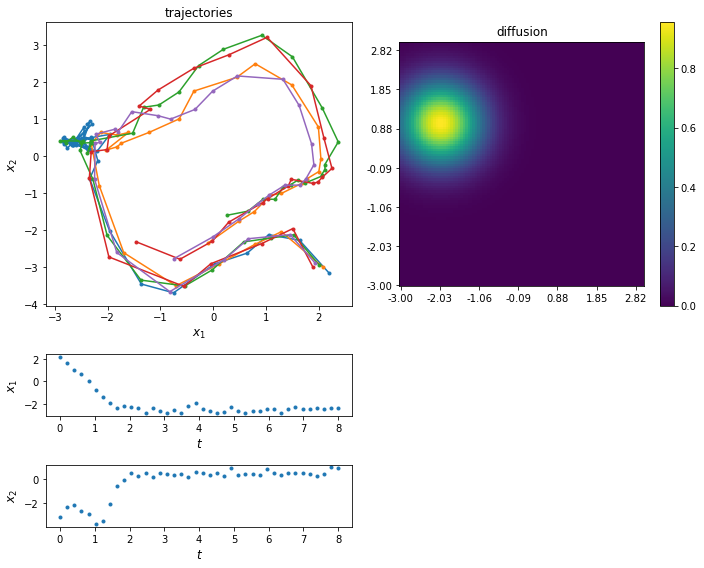

In [23]:
np.random.seed(918273)
x0,t,Y,X,D,f,g = gen_data('vdp-sdiff', Ny=[40,30,40,30,30], tend=8, nstd=0.1)

In [24]:
Y

array([ array([[ 2.19566574, -3.15912487],
       [ 1.63558973, -2.27563676],
       [ 1.05157155, -2.12001082],
       [ 0.64312532, -2.61897551],
       [ 0.0239358 , -2.91319137],
       [-0.75163397, -3.69056264],
       [-1.36208455, -3.45408225],
       [-1.96351375, -2.01927127],
       [-2.34133654, -0.61357037],
       [-2.1878387 , -0.1210626 ],
       [-2.3109003 ,  0.51204421],
       [-2.36391215,  0.19884443],
       [-2.82774569,  0.50191252],
       [-2.3649582 ,  0.15135318],
       [-2.62161247,  0.46628332],
       [-2.86156216,  0.4117907 ],
       [-2.59494583,  0.29894083],
       [-2.82866184,  0.38686265],
       [-2.19888042,  0.1316687 ],
       [-1.9588554 ,  0.58525737],
       [-2.49231717,  0.45230058],
       [-2.66322485,  0.29760629],
       [-2.85522244,  0.47628026],
       [-2.7679826 ,  0.21173762],
       [-2.30100539,  0.85789262],
       [-2.66214803,  0.28849698],
       [-2.78486536,  0.36755614],
       [-2.64298563,  0.3945225 ],
       [-2.6

### Inference

Model being initialized...
(200, 40, 2)
Adam optimizer being initialized...
Optimization starts.
       iteration       objective
               1        1000.547
             100         485.022
             200         387.045
             300         331.240
             400         283.520
             500         278.030
Optimization ends.
Plotting...
noise variance:        [0.04216942 0.02260516]
signal variance:       1.58176140843905
lengthscales:          [0.88841244 1.03382084]
diff signal variance:  1.2055280894682274
diff lengthscales:     [0.93708712]


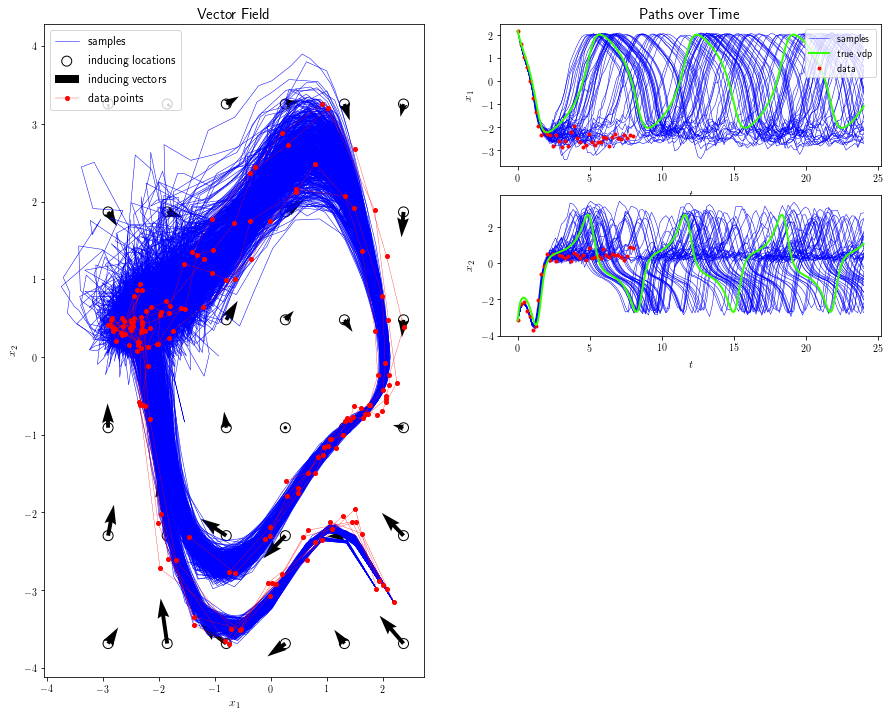

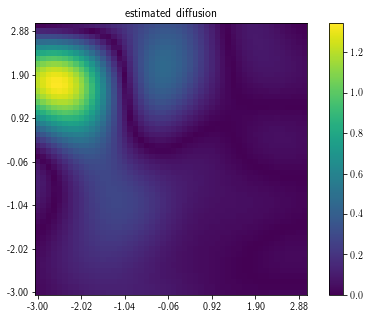

In [9]:

npde = npde_fit(sess, t, Y, model='sde', sf0=1.0, ell0=[1.0,1.0], ellg0=[1.0], W=6, ktype="id", 
                fix_Z=True, Nw=200, num_iter=500, print_int=100, eta=0.01, plot_=True)